## <center> **<span style="color: red">NLP</span> steps and explnation.**

Here we will use <span style="color: #ffd21e">**Hugging face**</span> trasformers pre trained models becuase it'll take so much effort to label<br>
all of our text columns "<ins>Comments, Describtion, Title</ins>" and also we will extract categorical and numirecal<br>
features from the text columns.<br><br>

##### **Steps in detail:**
<ul>
    <li>Extract categorical features from text columns sush as:<ol> 
        <li>Contains emojies
        <li>Positive or negative
        <li>Language
        <li>Video stats range</ol>
    <li> Doing analysis for most common words in comments and titles (Word cloud)
    <li> Extracing the length of the comments, descriptions & titles
    <li> One hot encoding
    <li> Stemming the data and tokenizing it
    <li> Saving those new data into new <strong>one</strong> Df to use in the final ML model

##### **Important note:**
The data in this analysis may be a little bit biased becuase all comments is made to be at least more than <br>
$50$.

## <center> **Importing the <span style="color: red">Packeges</span>**<br>

In [45]:
import os
import time
import nltk
import emoji
import pickle
import sqlite3
import svgwrite
import pandas as pd
import numpy as np
import transformers
import huggingface_hub

from PIL import Image
import matplotlib.pyplot as plt

from IPython.display import (
    set_matplotlib_formats)

from wordcloud import (WordCloud,
                       STOPWORDS,
                       ImageColorGenerator)

In [48]:
with open("../Data analysis/functions/z-score.pickle", "rb") as f:
    z_score = pickle.load(f)

huggingface_hub.notebook_login()
set_matplotlib_formats('pdf', 'svg')

C:\Users\FreeComp\AppData\Local\Temp\ipykernel_10900\2025956571.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


## <center> **Reading the <span style="color: red">data</span>**

In [49]:
con = sqlite3.connect('../database.db')

df = pd.read_sql_query("""   
                        
                        SELECT *
                        FROM base_videos AS bv

                        INNER JOIN base_channels  AS bc ON
                            bc.channel_name = bv.channelTitle

                        INNER JOIN comments  AS c ON
                            c.video_id = bv.video_id""", con)

con.close()

df = df.T.drop_duplicates().T # dropping duplicated cols

In [50]:
df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,duration_in_minutes,subscribers,total_views,date,video_count,about,country,Comments,LikeCounts,ReplyCounts
1470,wYTxLEKUpUM,Displaced Gamers,Blaster Master Pause Glitch and Rotating Tanks...,Some bosses take damage even with the game pau...,"['pause glitch', 'pause trick', 'explained', '...",2021-11-26 15:00:30+00:00,35809,2348,162,hd,16.734375,85700,6736374,2014-12-04 00:00:00,102,"Gaming - Discussion, Tech, and more.",US,I've always thought the pause trick was intent...,3,0
4552,I_CwFdp5vHo,Judo Sloth Gaming,Builder Base 2.0 - Everything You Need to Know!,Builder Base 2 is coming to Clash of Clans! Ju...,"['clash of clans', 'coc', 'judo sloth', 'clash...",2023-02-25 15:30:04+00:00,1024904,50012,1637,hd,8.867188,2400000,473754517,2014-02-04 00:00:00,1784,A Clash of Clans based channel focusing on hel...,GB,i just got the 6th builder yesterday after lik...,0,0
3548,aiyLtxUPD0s,The Frustrated Gamer,I Found The DUMBEST WAYS TO DIE!,I Found The Dumbest ways to die | The Frustrat...,"['dumb ways to die', 'dumb ways to die 2', 'du...",2023-04-04 10:45:00+00:00,262028,4300,888,hd,12.796875,2300000,1271155349,2018-02-08 00:00:00,2013,What is going on everybody?! I am Brandon AKA ...,US,Kick the opposite side when it is on proper st...,0,0
1722,frLOBi17fRg,نينجا جيمنج NINJA Gaming l,تفجير بكجات هكرات اللعبة.!🔥طلعلي أقوي اللاعبين...,تفتيح بكج ابطال اي فوتبول والحظ اسطوري في بيس ...,"['بيس موبايل', 'بيس 23 موبايل', 'بيس 2023 موبا...",2023-03-28 19:01:06+00:00,42975,6109,168,hd,19.0,222000,17569910,2019-05-03 00:00:00,352,S200N K\n,EG,تيشرت برشلونه اللى ورا هاى كوبي ولا بلاير اديشن,0,0
3540,aiyLtxUPD0s,The Frustrated Gamer,I Found The DUMBEST WAYS TO DIE!,I Found The Dumbest ways to die | The Frustrat...,"['dumb ways to die', 'dumb ways to die 2', 'du...",2023-04-04 10:45:00+00:00,262028,4300,888,hd,12.796875,2300000,1271155349,2018-02-08 00:00:00,2013,What is going on everybody?! I am Brandon AKA ...,US,"Brandon,when it shows the safe thing on the sc...",0,0


##  <center> **Extract <span style="color: red">categorical</span> features**

#### *Extract emojies count per text*

In [51]:
comments_emojis_counts: list = []
title_emojis_counts: list = []
desc_emojis_counts: list = []

for comment, title, desc in zip(df["Comments"], df["title"], df["description"]):
    
    comments_emojis_count: int = 0
    title_emojis_count: int = 0
    desc_emojis_count: int = 0
    
    for comment_char, title_char, desc_char in zip(comment, title, desc):
        
        if emoji.is_emoji(comment_char):
            comments_emojis_count += 1
            
        if emoji.is_emoji(title_char):
            title_emojis_count += 1
            
        if emoji.is_emoji(desc_char):
            desc_emojis_count += 1
    
    comments_emojis_counts.append(comments_emojis_count)
    title_emojis_counts.append(title_emojis_count)
    desc_emojis_counts.append(desc_emojis_count)

In [52]:
df["comments_emojis_count"] = comments_emojis_counts
df["title_emojis_count"] = title_emojis_counts
df["desc_emojis_count"] = desc_emojis_counts

df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,...,date,video_count,about,country,Comments,LikeCounts,ReplyCounts,comments_emojis_count,title_emojis_count,desc_emojis_count
5057,cquIUaRc7X4,Navrit Gaming Extraa,Selling 1000 Pineapples at General Store - Ran...,In this new episode of Ranch Simulator I sold ...,"['ranch simulator', 'ranch simulator gameplay'...",2022-12-25 06:52:24+00:00,170673,8280,223,hd,...,2021-03-27 00:00:00,153,"This is my second gaming channel, where I uplo...",IN,Aap painappel ko egg ki basket mein rakho,0,0,0,0,0
4838,k7UPi0WT28A,PAYAL GAMING,LATE NIGHT STREAM 💞|| PAYAL IS LIVE 😍,https://linktr.ee/AMDgaminguniverse\n\n➤ Becom...,"['PAYAL', 'PAYAL GAMING', 'Payal gaming LIVE',...",2023-02-22 20:35:46+00:00,99488,10132,148,hd,...,2019-03-01 00:00:00,609,Hey there! Welcome to my channel! My name is P...,IN,Garibo ke comments pe bhi dhyan diya kro😀😃,1,1,0,2,0
4267,S3GzVEEZbUw,Sopo Squad Gaming,"We Trade the ""NEW"" NEON FIREFLY in Roblox Adop...","We Trade the ""NEW"" NEON FIREFLY in Roblox Adop...","['Sopo', 'Sopo squad', 'Sopo squad gaming', 'A...",2023-02-17 12:30:26+00:00,54718,1222,173,hd,...,2019-06-20 00:00:00,575,Roblox gaming family!! It's the Sopo Squad! Wa...,US,Hi sopo squad I'm ur big fan can u please offe...,0,0,0,1,1
2526,T1PM4X1juZM,MixiGaming,Mixi Funny Moment #10: Tổng hợp những tình huố...,Chúc các bạn xem stream vui vẻ.\n\n►Lịch Live:...,"['Mixigaming', 'Mixi', 'Độ Tày', 'Streamer Mix...",2023-03-24 02:00:13+00:00,467478,9244,174,hd,...,2012-11-24 00:00:00,2247,- Mình là Độ -\n\n- Thỉnh thoảng rảnh chó ko c...,VN,Tôi rất thích thương hiệu này ❤❤❤❤,0,0,4,0,0
3342,JWn3ZznSG4E,ERWIN GAMING,GTA V ထဲမှာ Mr Meat ဝက်ဘီလူးကြီးကို တွေ့ခဲ့တယ်...,GTA V\nGTA V Myanmar\nGTA 5\nGTA 5 Roleplay\nG...,"['GTA 5', 'GTA 5 Myanmar', 'GTA V', 'GTA V Mya...",2023-02-12 05:29:34+00:00,166959,2502,143,hd,...,2021-10-17 00:00:00,382,I like playing games with mods. 😁☺️,SG,you city is very beautiful and I like this vid...,2,1,1,3,0


#### *Language detection*

In [7]:
language_detector = transformers.pipeline("text-classification",
                                          model="papluca/xlm-roberta-base-language-detection",
                                          use_auth_token= True)

In [8]:
%%timeit
print(language_detector("هذا أطول نص قد تقرأه على الإطلاق إنه طويل للغاية", max_length=128))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
3.63 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Looks like we will take a lot to <ins>just classify the language</ins> of each text at least: $30\times100$ second whitch equalls <span style="color: red">**50 minutes.**</span><br>
So we can't do translation for now becuase it at least may take **5 hours** to run so we will just use this language detetion and<br>
optimize it by just sellecting one text column to detect which will be **Description column** and use the detected languages to<br>
pridect video and comments language.<br><br>
But we will detect the language using the **country of this video**

In [9]:
df["country"].unique()

array(['DE', 'US', 'PL', 'SA', 'NP', 'CA', 'ES', 'TR', 'IN', 'EG', 'GB',
       'MX', 'BR', 'PK', 'FR', 'VN', 'ID', 'AU', 'HU', 'NL', 'BG', 'JP',
       'SG', 'TH', 'PH', 'MT', 'PE', 'SE', 'IT', 'KR', 'TW', 'FI', 'DZ',
       'BD', 'AR'], dtype=object)

In [10]:
country_languages = {
    'DE': 'German',
    'US': 'English', 'PL': 'Polish',
    'SA': 'Arabic', 'NP': 'Nepali',
    'CA': 'English', 'ES': 'Spanish',
    'TR': 'Turkish', 'IN': 'Hindi',
    'EG': 'Arabic', 'GB': 'English',
    'MX': 'Spanish', 'BR': 'Portuguese',
    'PK': 'Urdu', 'FR': 'French',
    'VN': 'Vietnamese', 'ID': 'Indonesian',
    'AU': 'English', 'HU': 'Hungarian',
    'NL': 'Dutch', 'BG': 'Bulgarian',
    'JP': 'Japanese', 'SG': 'English', 
    'TH': 'Thai', 'PH': 'Tagalog',
    'MT': 'Maltese', 'PE': 'Spanish',
    'SE': 'Swedish', 'IT': 'Italian',
    'KR': 'Korean', 'TW': 'Chinese',
    'FI': 'Finnish', 'DZ': 'Arabic',
    'BD': 'Bengali', 'AR': 'Spanish'}

df["language"] = df["country"].replace(country_languages)

This way may not be so accurate in detecting languages becuase there are some **indian videos** specifically with english and<br>
because some commetns come in deffrint languages but at least this way is more accurate than `roberta-language-detection`<br>
model because this model sometimes come with wierd 

#### *Sentiment analysis*

In [11]:
sentiment_classifier = transformers.pipeline(model= "finiteautomata/bertweet-base-sentiment-analysis")
print(sentiment_classifier("Hello here in my analysis, Have a nice day !!"))

Downloading:   0%|          | 0.00/2.72k [00:00<?, ?B/s]

[{'label': 'POS', 'score': 0.9883897304534912}]


In [12]:
def my_sentiment_classifier(text: str) -> np.int8:
    """This code takes a text and return you if it's positive
        or negative as 1 for positive, 0 for natural -1 for negative
        and -10 for unclassified.
    
    @params: a string text
    @return: 1, 0 or -1 in np.int8 dtype"""
    
    sentiment_type_encoder: dict = {"POS": 1,
                                    "NEG": -1,
                                    "NEU": 0,
                                    "unclassified": -10}
    
    try:
        sentiment_type: str = sentiment_classifier(text)[0]["label"]
        
    except:
        sentiment_type: str = "unclassified"
        
    return  np.int8(sentiment_type_encoder[sentiment_type])

In [ ]:
df["sentiments"] = df["Comments"][:5].apply(
    lambda x: my_sentiment_classifier(x))

In [ ]:
df[["sentiments", "Comments"]]

#### *Video stats range*

We will classify each column of **[Comments, Likes, Views, Subscribers]** into 6 groups manually like:
<ul>
    <li>  $1\sim3,000$ Views
    <li>  $3,000\sim10,000$ Views
    <li>  $10,000\sim50,000$ Views
    <li>  $50,000\sim100,000$ Views
    <li>  $100,000\sim300,000$ Views
    <li>  $300,000\sim\infty$

We will see the max calues of each column so we can optimize it with the best dtype for it.

In [57]:
print(f" The max value of view count column is: {df['viewCount'].astype(int).max()}\n",
      f"The max value of like count column ias: {df['likeCount'].astype(int).max()}\n",
      f"The max value of comment count column is: {df['commentCount'].astype(int).max()}\n",
      f"The max value of subscribers column is: {df['subscribers'].astype(int).max()}\n")

 The max value of view count column is: 31882044
 The max value of like count column is: 927266
 The max value of comment count column is: 33778
 The max value of subscribers column is: 34700000



In [58]:
df = df.astype({"commentCount": np.uint16, "viewCount": np.uint32,
                "likeCount": np.uint16, "subscribers": np.uint32})

df.describe()

,viewCount,likeCount,commentCount,subscribers,comments_emojis_count,title_emojis_count,desc_emojis_count
count,6.075000e+03,6075.000000,6075.000000,6.075000e+03,6075.000000,6075.000000,6075.000000
mean,7.188322e+05,11636.275391,1062.780082,2.165070e+06,0.734486,0.180905,0.144527
std,2.851364e+06,13827.905657,3082.573659,4.809393e+06,3.680049,0.553402,0.450570
min,2.796000e+03,189.000000,101.000000,9.850000e+03,0.000000,0.000000,0.000000
25%,5.471800e+04,2348.000000,174.000000,2.280000e+05,0.000000,0.000000,0.000000
50%,1.467240e+05,6949.000000,324.000000,6.340000e+05,0.000000,0.000000,0.000000
75%,4.220410e+05,15005.000000,746.000000,2.080000e+06,0.000000,0.000000,0.000000
max,3.188204e+07,65388.000000,33778.000000,3.470000e+07,84.000000,5.000000,4.000000


In [ ]:
df["cat_view_count"] = pd.cut(df['viewCount'],
                         bins=[1, 3_000, 10_000, 50_000, 100_000, 300_000, 999_999_999_999],
                         labels=["from 1 to 3,000", "from 3,000 to 10,000",
                                 "from 10,000 to 50,000", "from 50,000 to 100,000",
                                 "from 100,000 to 300,000", "from 300,000 to infinity"])

df["cat_like_count"] = pd.cut(df['likeCount'],
                         bins=[1, 3_000, 10_000, 50_000, 100_000, 300_000, 999_999_999_999],
                         labels=["from 1 to 3,000", "from 3,000 to 10,000",
                                 "from 10,000 to 50,000", "from 50,000 to 100,000",
                                 "from 100,000 to 300,000", "from 300,000 to infinity"])

df["cat_comment_count"] = pd.cut(df['commentCount'],
                         bins=[1, 3_000, 10_000, 50_000, 100_000, 300_000, 999_999_999_999],
                         labels=["from 1 to 3,000", "from 3,000 to 10,000",
                                 "from 10,000 to 50,000", "from 50,000 to 100,000",
                                 "from 100,000 to 300,000", "from 300,000 to infinity"])

df["cat_view_count"] = pd.cut(df['viewCount'],
                         bins=[1, 3_000, 10_000, 50_000, 100_000, 300_000, 999_999_999_999],
                         labels=["from 1 to 3,000", "from 3,000 to 10,000",
                                 "from 10,000 to 50,000", "from 50,000 to 100,000",
                                 "from 100,000 to 300,000", "from 300,000 to infinity"])

## <center><strong>Text visualiztion with<span style = "color: red"> WordCloud</span></strong></center>

In [31]:
coloring = np.array(Image.open("../imgs/youtube_gaming_logo.png"))
stopwords = set(STOPWORDS)

comments = ''.join(df["Comments"][df["language"] == "English"].values.flatten())

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


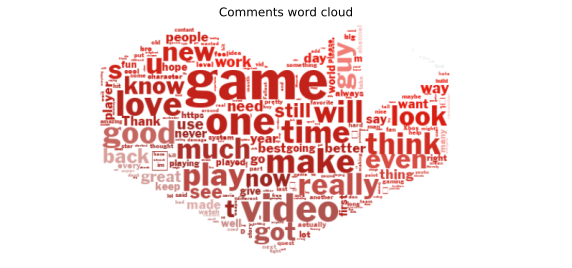

In [36]:
comments_wc = WordCloud(background_color= "white", max_words= 300, mask= coloring,
               stopwords= stopwords, max_font_size= 80, random_state= 42,
               font_path= '../Data analysis/assets/fonts/FranklinGothic.ttf',
               collocations=False)

image_colors = ImageColorGenerator(np.array(coloring))
comments_wc.generate(comments)
comments_wc = comments_wc.recolor(color_func= image_colors)

comments_svg = comments_wc.to_svg(embed_font=True)

# Save the SVG code to a file
with open("../plots/comments_word_cloud.svg", "w", encoding="utf-8") as f:
    f.write(comments_svg)
    
fig, ax = plt.subplots(1)

ax.imshow(comments_wc, interpolation="bilinear")
ax.set_axis_off()

plt.title("Comments word cloud")
fig.set_size_inches(10, 8)
plt.savefig("../plots/comments_word_cloud.png")
plt.show()

Now we will make a word cloud for **video titles data**

In [24]:
popular_emojis = ["😊", "😍", "😘", "😜", "😝", "😂", "😭", "😡", "😠", "😩", "😫", "😞", "😟", "😢", "😥", "😰", "😱",
                       "😳", "😷", "👍", "👎", "👌", "👏", "🙌", "👋", "💪", "🙏", "❤️", "💔", "💕", "💖", "💘", "💙", "💚",
                       "💛", "💜", "💯", "🔥", "🌟", "✨", "⭐", "🌈", "🌺", "🍕", "🍔", "🍟", "🍦", "🍭", "🍩", "🍪", "🍺",
                       "🍻", "🍷", "🍸", "🎂", "🎁", "🎉", "🎊", "🎈", "🎵", "🎶", "🎼", "🎧", "🎤", "🎸", "🎹", "🎺", "🎷",
                       "🎻", "🎬", "🎥", "🎦", "📷", "📹", "📺", "📻", "💻", "📱", "💡", "🔑", "🔨", "🔥", "💰", "💳", "💼",
                       "📅", "📆", "📈", "📉", "📊", "📋", "📎", "📏", "📐", "🔒", "🔓", "🔍", "🔎", "🚀", "🚑", "🚒", "🚓",
                       "🚕", "🚗", "🚙", "🚚", "🚢", "🚤", "🚲", "🚶", "🚶‍♀️", "🏃", "🏃‍♀️", "⚽", "🏀", "🏈", "🎾", "🏐", "🏉",
                       "🎱", "🏓", "🏸", "🥊", "🥋", "🎮", "🕹️", "🎲", "🃏"]


for emoji in popular_emojis:
    stopwords.add(emoji)
    
titels = ''.join(df["title"][df["language"] == "English"].values.flatten())

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


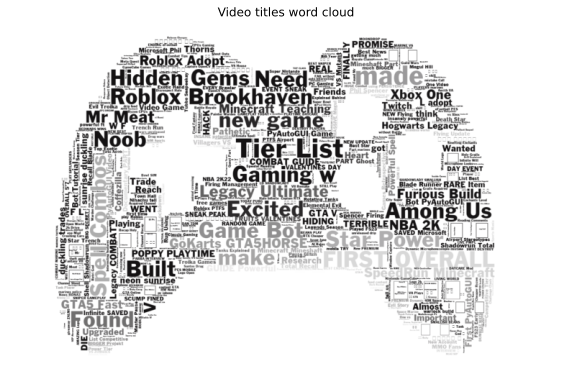

In [39]:
coloring = np.array(Image.open("../imgs/joystick.png"))

titels_wc = WordCloud(background_color= "white", max_words= 2000, mask= coloring,
               stopwords= stopwords, max_font_size= 80, random_state= 42,
               font_path= '../Data analysis/assets/fonts/FranklinGothic.ttf')

titels_wc.generate(titels)
image_colors = ImageColorGenerator(np.array(coloring))
titels_wc = titels_wc.recolor(color_func= image_colors)


fig, ax = plt.subplots(1)

ax.imshow(titels_wc, interpolation= "bilinear")
ax.set_axis_off()

titels_svg = titels_wc.to_svg(embed_font=True)

with open("../plots/videos_titels_word_cloud.svg", "w", encoding="utf-8") as f:
    f.write(titels_svg)

plt.title("Video titles word cloud")
fig.set_size_inches(10, 8)
plt.savefig("../plots/videos_titels_word_cloud.png")
plt.show()

## <center><strong><span style = "color: red">Extra</span> features